In [51]:
import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")
import model
import tunneling
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import scienceplots

In [112]:
def init_run(N):
    
    voltages                    = np.random.uniform(low=-0.3, high=0.3, size=(16,3))        
    topology_parameter          = {}
    topology_parameter["Np"]    = N
    topology_parameter["Nj"]    = 2
    topology_parameter["e_pos"] = [[-1.5,-1.5],[1.5,1.5]]
    sim_class                   = model.simulation(voltages)
    sim_class.init_random("",topology_parameter) 

    sim_class.net_electrostatic.init_charge_vector(voltage_values=voltages[0])
    inv_capacitance_matrix  = sim_class.net_electrostatic.return_inv_capacitance_matrix()
    charge_vector           = sim_class.net_electrostatic.return_charge_vector()

    # Model
    net_model = tunneling.tunnel_class(net_topology=sim_class.net_topology, inv_capacitance_matrix=inv_capacitance_matrix)
    net_model.init_potential_vector(voltage_values=voltages[0])
    net_model.init_const_capacitance_values()

    # Return Model Arguments
    potential_vector                                                                        = net_model.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = net_model.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = net_model.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = net_model.return_advanced_indices()
    temperatures, temperatures_co                                                           = net_model.return_const_temperatures(T=0)
    resistances, resistances_co1, resistances_co2                                           = net_model.return_const_resistances()

    # Simulation Class
    summary = model.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles)
    
    return summary

In [126]:
Ns      = np.arange(3,501)
Nss     = []
times1  = []
times1s = []
times2  = []
times2s = []
times3  = []
times3s = []

for N in Ns:

    tt1 = []
    tt2 = []
    tt3 = []

    summary = init_run(N)
    summary.calc_potentials()
    
    for i in range(100000):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        
        summary.calc_tunnel_rates_zero_T()
        summary.select_event(random_number1, random_number2)
    
    for i in range(10000):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        
        t1 = time.process_time_ns()
        summary.calc_tunnel_rates_zero_T()
        
        t2 = time.process_time_ns()
        summary.select_event(random_number1, random_number2)

        t3 = time.process_time_ns()

        tt1.append(t2-t1)
        tt2.append(t3-t2)
        tt3.append(t3-t1)

    Nss.append(len(summary.tunnel_rates))
    times1.append(np.mean(tt1))
    times1s.append(np.std(tt1))

    times2.append(np.mean(tt2))
    times2s.append(np.std(tt2))

    times3.append(np.mean(tt3))
    times3s.append(np.std(tt3))

In [115]:
results             = pd.DataFrame()
results['$N_{NP}$'] = Ns
results['$N_{T}$']  = Nss
results['t1']       = np.array(times1)/1000
results['t1s']      = np.array(times1s)/1000/np.sqrt(10000)
results['t2']       = np.array(times2)/1000
results['t2s']      = np.array(times2s)/1000/np.sqrt(10000)
results['t3']       = np.array(times3)/1000
results['t3s']      = np.array(times3s)/1000/np.sqrt(10000)
results

,$N_{NP}$,$N_{T}$,t1,t1s,t2,t2s,t3,t3s
0,3,10,1.45851,0.025478,1.04834,0.018483,2.50685,0.032662
1,4,12,1.71745,0.018335,1.23929,0.016127,2.95674,0.026966
2,5,14,1.59271,0.016401,1.15891,0.022858,2.75162,0.029707
3,6,16,1.30392,0.005496,0.89392,0.005548,2.19784,0.008143
4,7,18,1.46254,0.006246,1.12513,0.012070,2.58767,0.014682
...,...,...,...,...,...,...,...,...
193,196,396,3.95681,0.018247,1.89133,0.013433,5.84814,0.028586
194,197,398,3.91203,0.014331,1.85633,0.027567,5.76836,0.033078
195,198,400,4.02881,0.016948,1.88581,0.016404,5.91462,0.027257
196,199,402,3.95049,0.009697,1.82656,0.006779,5.77705,0.013404


In [116]:
cmeter      = 1/2.54
single_col  = 8.6

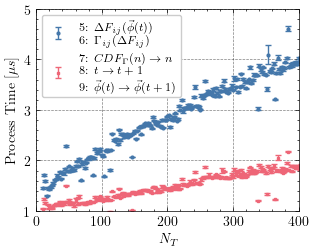

In [125]:
with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure()
    fig.set_figwidth(single_col*cmeter)
    ax  = fig.add_subplot()

    ax.errorbar(x=results['$N_{T}$'],y=results['t1'], yerr=results['t1s'], marker='o', ls='',
                label='5: $\Delta F_{ij}(\\vec{\phi}(t))$ \n 6: $\Gamma_{ij}(\Delta F_{ij})$',ms=2,capsize=2)
    ax.errorbar(x=results['$N_{T}$'],y=results['t2'], yerr=results['t2s'], marker='s', ls='',
                label='7: $CDF_{\Gamma}(n) \\rightarrow n$\n 8: $t \\rightarrow t+1$ \n 9: $\\vec{\phi}(t) \\rightarrow \\vec{\phi}(t+1)$',ms=2,capsize=2)
    ax.set_xlabel('$N_{T}$')
    ax.set_ylabel('Process Time [$\mu s$]')
    ax.legend(loc='upper left', fontsize='small',frameon=True)
    ax.set_ylim(1,5)
    ax.set_xlim(0,400)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    fig.savefig("complexity_vs_NT.pdf", bbox_inches='tight')
    fig.savefig("complexity_vs_NT.svg", bbox_inches='tight',transparent=True)
    plt.show()


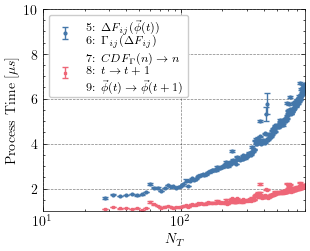

In [105]:
with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure()
    fig.set_figwidth(single_col*cmeter)
    ax  = fig.add_subplot()

    ax.errorbar(x=results['$N_{T}$'],y=results['t1'], yerr=results['t1s'], marker='o', ls='',
                label='5: $\Delta F_{ij}(\\vec{\phi}(t))$ \n 6: $\Gamma_{ij}(\Delta F_{ij})$',ms=2,capsize=2)
    ax.errorbar(x=results['$N_{T}$'],y=results['t2'], yerr=results['t2s'], marker='s', ls='',
                label='7: $CDF_{\Gamma}(n) \\rightarrow n$\n 8: $t \\rightarrow t+1$ \n 9: $\\vec{\phi}(t) \\rightarrow \\vec{\phi}(t+1)$',ms=2,capsize=2)
    ax.set_xlabel('$N_{T}$')
    ax.set_ylabel('Process Time [$\mu s$]')
    ax.legend(loc='upper left', fontsize='small',frameon=True)
    ax.set_ylim(1,10)
    ax.set_xlim(10,800)
    ax.set_xscale('log')
    # ax.set_yscale('log')
    fig.savefig("complexity_log_vs_NT.pdf", bbox_inches='tight')
    fig.savefig("complexity_log_vs_NT.svg", bbox_inches='tight',transparent=True)
    plt.show()


In [ ]:
time_ = 't2'
print(np.var(np.log(results[time_]/results['N'])))
print(np.var(np.log(results[time_]/(results['N']*np.log(results['N'])))))
print(np.var(np.log(results[time_]/np.log(results['N']))))
# print(np.var(np.log(results[time_]/np.sqrt(results['N']))))

In [ ]:
times   = []
Ns      = np.arange(10000,10*10000)
for N in Ns:

    x   = np.random.uniform(-1,1,N)
    y   = np.random.uniform(-1,1,N)

    t1  = time.process_time_ns()
    z   = x+y
    t2  = time.process_time_ns()

    times.append(t2-t1)

In [ ]:
plt.plot(times, '.')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [ ]:
import networkx as nx

In [ ]:
N_particles    = 50
N_junctions    = 4
not_connected       = True

# Generate random graphs until a graph is connected
while not_connected:

    G          = nx.random_regular_graph(N_junctions, N_particles)
    not_connected   = not(nx.is_connected(G))

G   = G.to_directed()
pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, pos=pos)

In [ ]:
nx.draw_networkx(G, pos)
plt.show()

In [ ]:
G = nx.grid_graph(dim=(5,5,1))
G.nodes

In [ ]:
G_new = nx.convert_node_labels_to_integers(G)
G_new = G_new.to_directed()

In [ ]:
G_new.edges

In [ ]:
nx.draw_networkx(G_new)
plt.show()